# 1. Import Packages

In [2]:
import eli5
import shap
import pickle
import warnings
import numpy as np
import pandas as pd
import librosa as lr
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import sklearn.metrics as metrics

from IPython.display import HTML
from tensorflow.keras import Input
from sklearn.metrics import f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from eli5.sklearn import PermutationImportance

warnings.filterwarnings("ignore")

In [3]:
# Creates a button to toggle on/off the raw code

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# 2. Importing Preprocessed Data

In [4]:
def import_pkl(path):
    data = []
    with (open(path, 'rb')) as openfile:
        while True:
            try:
                data = pickle.load(openfile)
            except EOFError:
                break
    return data['X_train'], data['y_train'], data['X_test'], data['y_test']

In [5]:
train00_X, train00_y, test00_X, test00_y = import_pkl('../data/id_00.pkl')
train02_X, train02_y, test02_X, test02_y = import_pkl('../data/id_02.pkl')
train04_X, train04_y, test04_X, test04_y = import_pkl('../data/id_04.pkl')
train06_X, train06_y, test06_X, test06_y = import_pkl('../data/id_06.pkl')

# 3. Creating a Baseline Architecture

In [6]:
def create_baseline(dim_x, dim_y):
    
    inputLayer = Input(shape = (dim_x, dim_y), name = 'baseline_autoencoder')
    h = Flatten()(inputLayer)
    h = Dense(64, activation = 'relu')(h)
    h = Dense(64, activation = 'relu')(h)
    h = Dense(8, activation = 'relu')(h)
    h = Dense(64, activation = 'relu')(h)
    h = Dense(64, activation = 'relu')(h)
    h = Dense(dim_x * dim_y, activation = None)(h)
    h = Reshape((dim_x, dim_y))(h)

    return Model(inputs = inputLayer, outputs = h)

# 4. Training Baseline Autoencoders

In [7]:
def train_model(X_train, n_mels, frame, lr, batch_size, epochs):
    model = create_baseline(n_mels, frame)
    print(model.summary())
    
    model.compile(loss = 'mean_squared_error', optimizer = Adam(learning_rate = lr), metrics = ['mse'])
    
    model_history = model.fit(X_train, X_train, batch_size = batch_size, validation_split = 0.1,
                         epochs = epochs, shuffle = True, verbose = 2)
    return model, model_history

In [9]:
baseline_models = []
for training_set in [train00_X, train02_X, train04_X, train06_X]:
    baseline_models.append(train_model(training_set, training_set[0].shape[0], 
                                      training_set[0].shape[1], 1e-3, 512, 50))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 baseline_autoencoder (Inpu  [(None, 64, 431)]         0         
 tLayer)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 27584)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                1765440   
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 64)                576       
                                                           

 dense_12 (Dense)            (None, 64)                1765440   
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
 dense_15 (Dense)            (None, 64)                576       
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 27584)             1792960   
                                                                 
 reshape_2 (Reshape)         (None, 64, 431)           0         
                                                                 
Total params: 3567816 (13.61 MB)
Trainable params: 3567816 (13.61 MB)
Non-tr

                                                                 
 dense_23 (Dense)            (None, 27584)             1792960   
                                                                 
 reshape_3 (Reshape)         (None, 64, 431)           0         
                                                                 
Total params: 3567816 (13.61 MB)
Trainable params: 3567816 (13.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
1/1 - 2s - loss: 2188.9294 - mse: 2188.9294 - val_loss: 1840.5938 - val_mse: 1840.5938 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 1s - loss: 1894.4948 - mse: 1894.4948 - val_loss: 1254.2709 - val_mse: 1254.2709 - 1s/epoch - 1s/step
Epoch 3/50
1/1 - 0s - loss: 1289.2314 - mse: 1289.2314 - val_loss: 779.8596 - val_mse: 779.8596 - 229ms/epoch - 229ms/step
Epoch 4/50
1/1 - 0s - loss: 800.6226 - mse: 800.6226 - val_loss: 375.3995 - val_mse: 375.3995 - 225ms/epoch - 225ms/step
Epoch 5/50


None
Epoch 1/50
2/2 - 2s - loss: 4026.9885 - mse: 4026.9885 - val_loss: 2945.6577 - val_mse: 2945.6577 - 2s/epoch - 889ms/step
Epoch 2/50
2/2 - 0s - loss: 2610.3040 - mse: 2610.3040 - val_loss: 1333.2670 - val_mse: 1333.2670 - 354ms/epoch - 177ms/step
Epoch 3/50
2/2 - 0s - loss: 1171.5179 - mse: 1171.5179 - val_loss: 319.5083 - val_mse: 319.5083 - 360ms/epoch - 180ms/step
Epoch 4/50
2/2 - 0s - loss: 277.4563 - mse: 277.4563 - val_loss: 232.4150 - val_mse: 232.4150 - 355ms/epoch - 178ms/step
Epoch 5/50
2/2 - 0s - loss: 251.2604 - mse: 251.2604 - val_loss: 312.9956 - val_mse: 312.9956 - 372ms/epoch - 186ms/step
Epoch 6/50
2/2 - 0s - loss: 322.8671 - mse: 322.8671 - val_loss: 319.0681 - val_mse: 319.0681 - 347ms/epoch - 174ms/step
Epoch 7/50
2/2 - 0s - loss: 302.7392 - mse: 302.7392 - val_loss: 229.7379 - val_mse: 229.7379 - 356ms/epoch - 178ms/step
Epoch 8/50
2/2 - 0s - loss: 217.9753 - mse: 217.9753 - val_loss: 142.0741 - val_mse: 142.0741 - 372ms/epoch - 186ms/step
Epoch 9/50
2/2 - 0s 

# 5. Evaluating the Baselines

In [14]:
reconstruction_errors_avg1 = []
reconstruction_errors_avg2 = []
for baseline in zip(baseline_models, [test00_X, test02_X, test04_X, test06_X]):
    predictions_temp = baseline[0][0].predict(baseline[1])
    reconstruction_errors_avg1.append(np.mean(np.square(baseline[1] - predictions_temp), axis = 1))
    reconstruction_errors_avg2.append(np.mean(np.mean(np.square(baseline[1] - predictions_temp), axis = 1), axis = 1))

10/10 [==============================] - 0s 5ms/step


### Reconstruction Error

In [15]:
def plot_reconstruction(error, y , axs, class_label):
    
    axs.set_title('Reconstruction Error: ' + class_label)
    
    bin_width = 10
    bins = np.arange(min(error), max(error) + (4 * bin_width), bin_width)

    axs.hist(error[y == 0], bins = bins, label = 'Normal signals', color = 'blue', alpha = 0.2)
    axs.hist(error[y == 1], bins = bins, label = 'Abnormal signals', color = 'red', alpha = 0.2)
    
    axs.set_xlabel("Testing Reconstruction Error")
    axs.set_ylabel("# Samples")
    axs.legend()

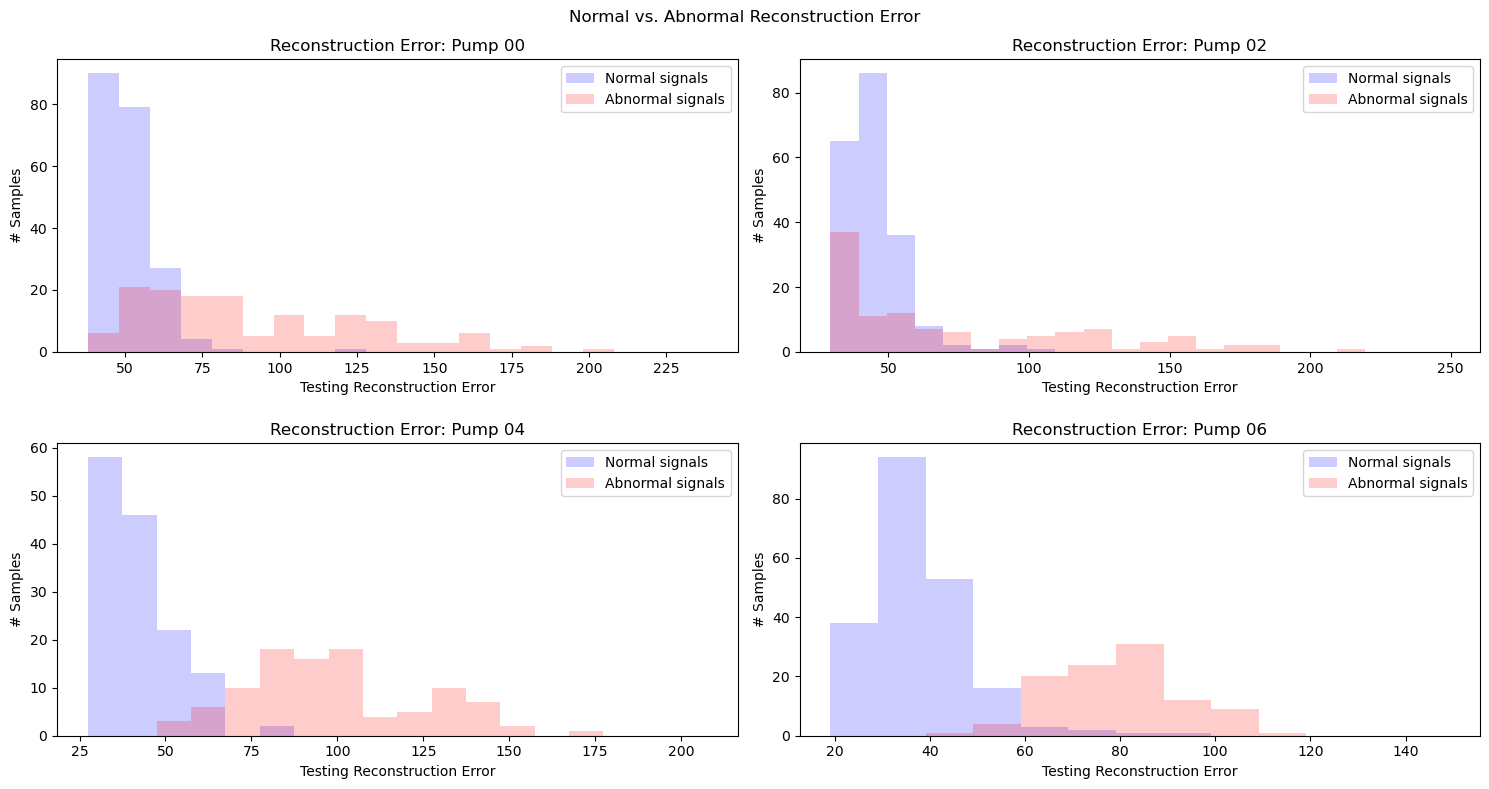

In [16]:
figure, axes = plt.subplots(2, 2, figsize = (15, 8))

figure.suptitle('Normal vs. Abnormal Reconstruction Error')

plot_reconstruction(reconstruction_errors_avg2[0], test00_y, axes[0,0], 'Pump 00')
plot_reconstruction(reconstruction_errors_avg2[1], test02_y, axes[0,1], 'Pump 02')
plot_reconstruction(reconstruction_errors_avg2[2], test04_y, axes[1,0], 'Pump 04')
plot_reconstruction(reconstruction_errors_avg2[3], test06_y, axes[1,1], 'Pump 06')

figure.tight_layout(h_pad = 2)
plt.show()

### Setting Error Thresholds

In [17]:
def plot_F1(error, y, axs, class_label):
    
    axs.set_title('F1 vs. Threshold: ' + class_label)
    
    thresholds = np.arange(min(error), max(error) + 5, 5)
    
    f1 = []
    
    for threshold in thresholds:
        predictions = np.where(error < threshold, 0, 1)
        f1.append(f1_score(y, predictions))

    axs.plot(thresholds, f1)
    
    axs.set_xlabel("Reconstruction Error Threshold")
    axs.set_ylabel("Model F1")
    
    max_threshold = thresholds[f1 == max(f1)][0]
    print(class_label + ' Max F1: ' + str(max(f1)))
    print(class_label + ' Best Threshold: ' + str(max_threshold))
    print('\n')
    return max_threshold

Pump 00 Max F1: 0.7945205479452055
Pump 00 Best Threshold: 58.018798828125


Pump 02 Max F1: 0.5888324873096448
Pump 02 Best Threshold: 54.40340614318848


Pump 04 Max F1: 0.9435897435897437
Pump 04 Best Threshold: 62.437381744384766


Pump 06 Max F1: 0.9417475728155339
Pump 06 Best Threshold: 59.14492416381836




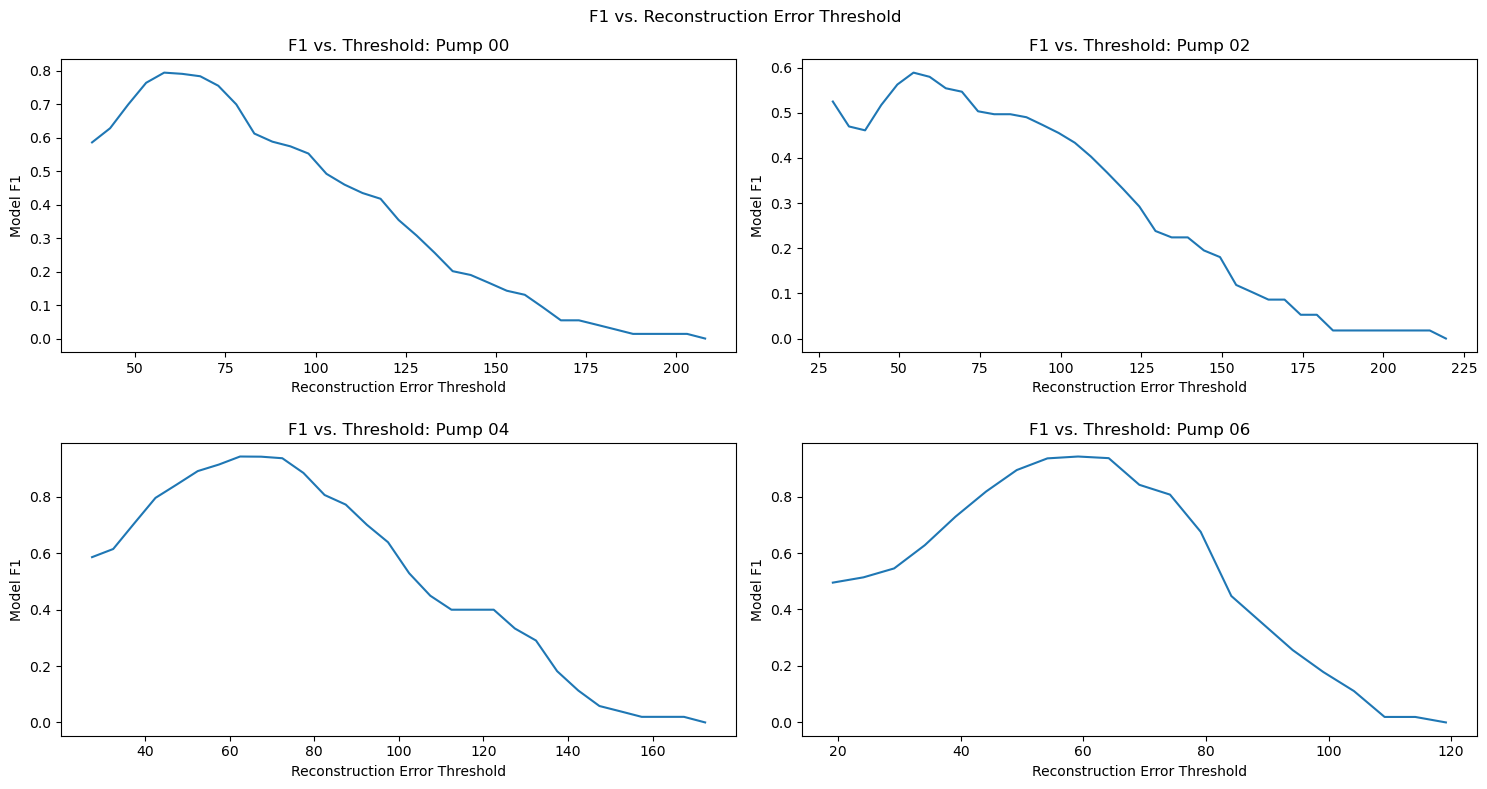

In [18]:
figure, axes = plt.subplots(2, 2, figsize = (15, 8))

figure.suptitle('F1 vs. Reconstruction Error Threshold')

max_threshold_00 = plot_F1(reconstruction_errors_avg2[0], test00_y, axes[0,0], 'Pump 00')
max_threshold_02 = plot_F1(reconstruction_errors_avg2[1], test02_y, axes[0,1], 'Pump 02')
max_threshold_04 = plot_F1(reconstruction_errors_avg2[2], test04_y, axes[1,0], 'Pump 04')
max_threshold_06 = plot_F1(reconstruction_errors_avg2[3], test06_y, axes[1,1], 'Pump 06')

figure.tight_layout(h_pad = 2)
plt.show()

### Confusion Matrix with Best Error Threshold

In [19]:
def print_stats(y_true, error, threshold, class_label):
    def get_predictions(error, threshold):
        return np.where(error < threshold, 0, 1)
    
    tn, fp, fn, tp = confusion_matrix(y_true, get_predictions(error, threshold)).ravel()
    
    print(class_label + ' True Negative: ' + str(tn))
    print(class_label + ' True Positive: ' + str(tp))
    print(class_label + ' False Negative: ' + str(fn))
    print(class_label + ' False Positive: ' + str(fp))
    
    return get_predictions(error, threshold)

In [20]:
pred_00 = print_stats(test00_y, reconstruction_errors_avg2[0], max_threshold_00, 'Pump 00')
print('\n')
pred_02 = print_stats(test02_y, reconstruction_errors_avg2[1], max_threshold_02, 'Pump 02')
print('\n')
pred_04 = print_stats(test04_y, reconstruction_errors_avg2[2], max_threshold_04, 'Pump 04')
print('\n')
pred_06 = print_stats(test06_y, reconstruction_errors_avg2[3], max_threshold_06, 'Pump 06')

Pump 00 True Negative: 169
Pump 00 True Positive: 116
Pump 00 False Negative: 27
Pump 00 False Positive: 33


Pump 02 True Negative: 173
Pump 02 True Positive: 58
Pump 02 False Negative: 53
Pump 02 False Positive: 28


Pump 04 True Negative: 138
Pump 04 True Positive: 92
Pump 04 False Negative: 8
Pump 04 False Positive: 3


Pump 06 True Negative: 201
Pump 06 True Positive: 97
Pump 06 False Negative: 5
Pump 06 False Positive: 7


### Plotting AUC

Pump 00: 
FPR: [0.         0.16336634 1.        ]
TPR: [0.         0.81118881 1.        ]


Pump 02: 
FPR: [0.         0.13930348 1.        ]
TPR: [0.         0.52252252 1.        ]


Pump 04: 
FPR: [0.        0.0212766 1.       ]
TPR: [0.   0.92 1.  ]


Pump 06: 
FPR: [0.         0.03365385 1.        ]
TPR: [0.         0.95098039 1.        ]




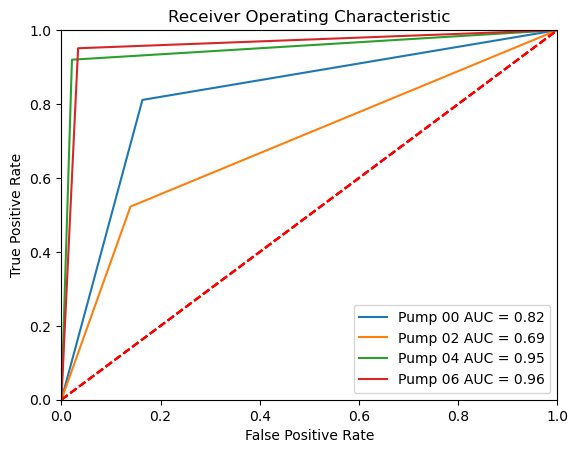

In [21]:
true = [test00_y, test02_y,test04_y, test06_y]
pred = [pred_00, pred_02, pred_04, pred_06]
class_labels = ['Pump 00', 'Pump 02', 'Pump 04', 'Pump 06']
auc_data = zip(true, pred, class_labels)
for data in auc_data:
    fpr, tpr, threshold = metrics.roc_curve(data[0], data[1])
    print(data[2] + ': ')
    print('FPR: ' + str(fpr))
    print('TPR: ' + str(tpr))
    print('\n')
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = data[2] + ' AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.show()

### Reconstruction Performance

In [22]:
def plot_heatmap(avg_error, axs, class_label):
    
    lr.display.specshow(avg_error, x_axis = 'time', y_axis = 'log', ax = axs)

    axs.set_title(class_label + ": Avg Error across Freqency and Time" + "\n")
    axs.set_xlabel("Time (Seconds)")
    axs.set_ylabel("Frequency (Hz)")

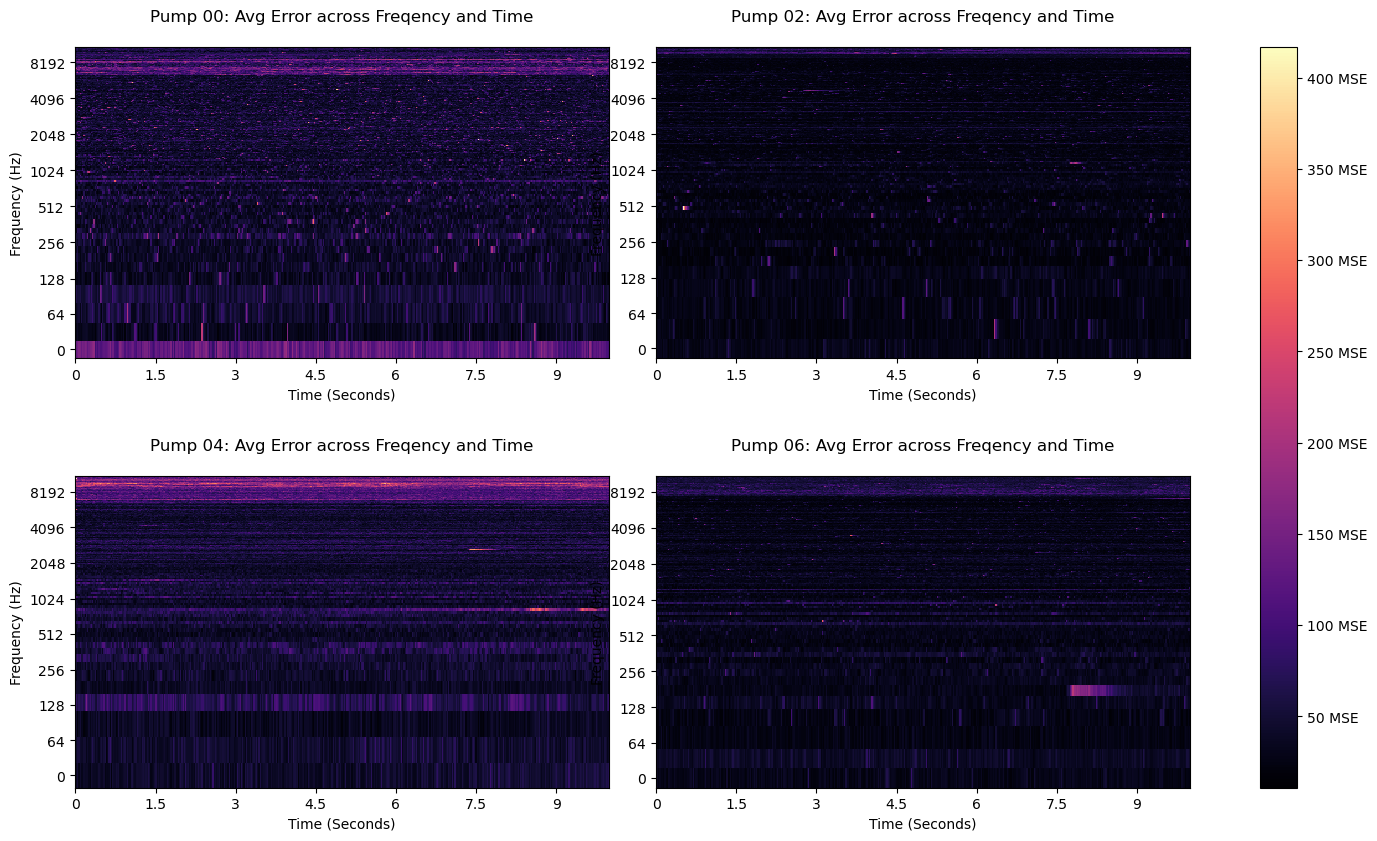

In [23]:
figure, axes = plt.subplots(2, 2, figsize = (15, 8))

img = lr.display.specshow(reconstruction_errors_avg1[0], x_axis = 'time', y_axis = 'log', ax = axes[0, 0])
figure.tight_layout(h_pad = 5)
figure.colorbar(img, ax = axes, format = "%2.f MSE")

plot_heatmap(reconstruction_errors_avg1[0], axes[0,0], 'Pump 00')
plot_heatmap(reconstruction_errors_avg1[1], axes[0,1], 'Pump 02')
plot_heatmap(reconstruction_errors_avg1[2], axes[1,0], 'Pump 04')
plot_heatmap(reconstruction_errors_avg1[3], axes[1,1], 'Pump 06')

plt.show()

### Feature Importance using SHAP

In [ ]:
# background = train00_X[np.random.choice(train00_X.shape[0], 100, replace = False)]
# explainer = shap.DeepExplainer((baseline_models[0][0].layers[0].input, baseline_models[0][0].layers[-1].output[0]), 
#                                background)

In [ ]:
# shap_values = explainer.shap_values(test00_X[0:5], check_additivity = False)

In [ ]:
# feature_names = get_frequencies(22050, 64)
# shap.image_plot(shap_values, test00_X[0:5])